(classifying_dogs_vs_cats)=
# Example: Classifying Images -  Dogs vs. Cats

The *Dogs vs. Cats dataset* is a popular dataset for binary image classification tasks. It consists of 25,000 images of dogs and cats, with 12,500 images of each class. The goal is to build a model that can accurately classify whether an image contains a dog or a cat.

## Download the Dataset

The *Dogs vs. Cats dataset* is not packaged with Keras. It was made available by Kaggle as part of a computer vision competition in late 2013. You can download the original dataset from [www.kaggle.com/c/dogs-vs-cats/data](https://www.kaggle.com/c/dogs-vs-cats/data) (you’ll need to create a Kaggle account if you don’t already have one). 

```{warning}

The following code assumes that you have already downloaded the dataset and unzipped it into a folder named `dogs-vs-cats` in your current working directory. The dataset contains two folders: `train` and `test`. The `train` folder contains 25,000 images of dogs and cats (that are labelled), while the `test` folder contains 12,500 images of dogs and cats (that are unlabelled).

```


In [1]:
import os
import shutil
import pathlib
original_dir = pathlib.Path("dogs-vs-cats/train") 
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [2]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category 
        # Create the directory if it doesn't exist
        if not dir.exists():
            os.makedirs(dir) 
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            print(original_dir / fname)
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

In [3]:
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

dogs-vs-cats/train/cat.0.jpg


FileNotFoundError: [Errno 2] No such file or directory: 'dogs-vs-cats/train/cat.0.jpg'

## Create the Dataset

We will use the ``image_dataset_from_directory`` utility to create a dataset from the downloaded images. This utility will automatically label the images based on their directory structure. 

In [53]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory( new_base_dir / "train", image_size=(180, 180), batch_size=32) 

validation_dataset = image_dataset_from_directory( new_base_dir / "validation", image_size=(180, 180), batch_size=32) 

test_dataset = image_dataset_from_directory( new_base_dir / "test", image_size=(180, 180), batch_size=32)

Found 2001 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [54]:
print(type(train_dataset))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


### Digression: Tensorflow Datasets

The `tf.data.Dataset` class in TensorFlow is a convenient way to build efficient, scalable data pipelines for machine learning. It helps you load, preprocess, and batch data to feed into your models during training, testing, or inference.


You typically start by creating a dataset from arrays, tensors, or generators.

Common ways include:

- `from_tensor_slices`: Creates a dataset from slices of tensors or arrays.
- `from_generator`: Creates a dataset from a generator function.
- `image_dataset_from_directory`: Create a dataset for image classification tasks directly from images stored in folders.


Datasets provide key methods to preprocess your data easily:

- **batch**: Combines dataset elements into batches for training.
- **shuffle**: Randomly shuffles the elements to reduce training bias.
- **map**: Applies a preprocessing function to each element.
- **prefetch**: Loads data ahead of time for improved training performance.

 
Using a `tf.data.Dataset` provides several important benefits:

- **Efficiency**: Optimized data loading and preprocessing reduces training time.
- **Scalability**: Handles very large datasets seamlessly.
- **Flexibility**: Makes preprocessing transparent and easy to maintain.

You can directly pass a dataset object to Keras model methods such as `model.fit()` or `model.evaluate()`, simplifying your training workflow.

In [ ]:
import tensorflow as tf

# Example data
X = [[1, 2], [3, 4], [5, 6], [7, 8]]
y = [0, 1, 0, 1]

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(3)

# Iterate over dataset
for batch_x, batch_y in dataset:
    print("Batch X:", batch_x.numpy())
    print("Batch y:", batch_y.numpy())
 

Batch X: [[1 2]
 [3 4]
 [5 6]]
Batch y: [0 1 0]


In [ ]:
import tensorflow as tf

(X_train, y_train), _ = tf.keras.datasets.mnist.load_data()

# Prepare dataset
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(10000) \
                 .batch(64) \
                 .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)) \
                 .prefetch(tf.data.AUTOTUNE)

# Fit model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(dataset, epochs=5, batch_size=32, verbose=0)

history.history['accuracy'][-1]  # Final accuracy

0.9824666380882263

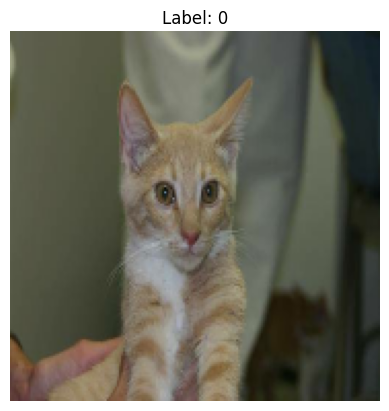

In [76]:
import matplotlib.pyplot as plt
import numpy as np
# Fetch the first batch from the dataset
for images, labels in train_dataset.take(1):
    first_image = images[0].numpy().astype("uint8")
    first_label = labels[0].numpy()

# Display the first image
plt.imshow(first_image)
plt.title(f"Label: {first_label}")
plt.axis('off')
plt.show()


## Create the Model

We will use a simple convolutional neural network (CNN) architecture for this task. The model will consist of several convolutional layers followed by max-pooling layers, and finally a fully connected layer with a softmax activation function for binary classification.

In [116]:
from tensorflow import keras 
from tensorflow.keras import layers

In [78]:
inputs = keras.Input(shape=(180, 180, 3)) 
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [79]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [ keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch.keras",
    save_best_only=True,
    monitor="val_loss")
    
]

history = model.fit(
    train_dataset, 
    epochs=30, 
    validation_data=validation_dataset, 
    callbacks=callbacks,
    verbose=0)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step - accuracy: 0.5000 - loss: 0.8022 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.5167 - loss: 0.6950 - val_accuracy: 0.5010 - val_loss: 0.7006
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.5300 - loss: 0.7146 - val_accuracy: 0.5570 - val_loss: 0.6803
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 279ms/step - accuracy: 0.5863 - loss: 0.6926 - val_accuracy: 0.6160 - val_loss: 0.6379
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 289ms/step - accuracy: 0.6275 - loss: 0.6480 - val_accuracy: 0.6800 - val_loss: 0.6071
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.6873 - loss: 0.6017 - val_accuracy: 0.6100 - val_loss: 0.6368
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - accuracy: 0.7203 - loss: 0.5653 - val_accuracy: 0.6280 - val_loss: 0.6287
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - accuracy: 0.7216 - loss: 0.5507 - val_accu

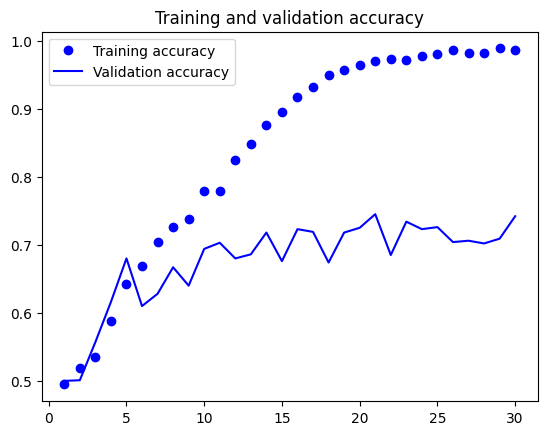

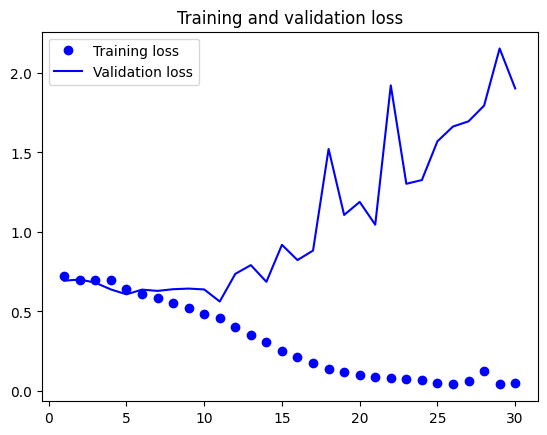

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)


plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") 
plt.title("Training and validation accuracy") 
plt.legend() 
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")

plt.plot(epochs, val_loss, "b", label="Validation loss") 
plt.title("Training and validation loss") 
plt.legend() 
plt.show()

In [85]:
import os

test_model = keras.models.load_model("convnet_from_scratch.keras")

test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.7104 - loss: 0.5777
Test accuracy: 0.698


## Dealing with Overfitting - Data Augmentation

One approach to reduce overfitting is to use data augmentation. Data augmentation is a technique that artificially increases the size of the training dataset by applying random transformations to the images, such as rotation, zoom, and flipping. This helps the model generalize better to unseen data.

In [86]:
data_augmentation = keras.Sequential( [ 
    layers.RandomFlip("horizontal"), 
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2), ] 
    )

2025-04-07 19:49:41.643322: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


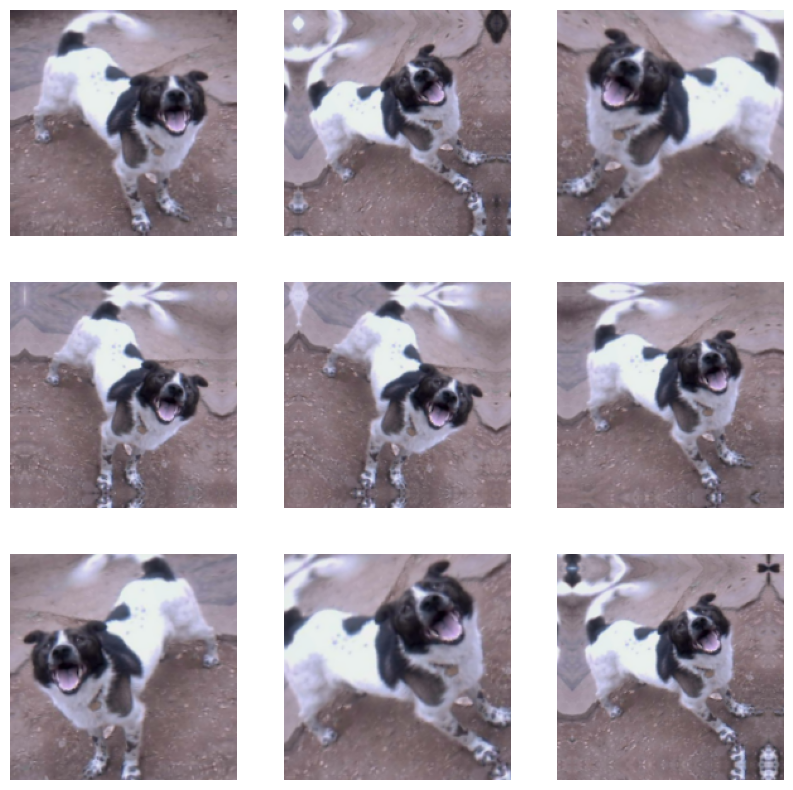

In [90]:
plt.figure(figsize=(10, 10))

for images, _ in train_dataset.take(1): 
    for i in range(9):  
        augmented_images = data_augmentation(images) 
        ax = plt.subplot(3, 3, i + 1) 
        plt.imshow(augmented_images[0].numpy().astype("uint8")) 
        plt.axis("off")

In [91]:
inputs = keras.Input(shape=(180, 180, 3)) 

x = data_augmentation(inputs) 
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x) 
x = layers.Dropout(0.5)(x) 
outputs = layers.Dense(1, activation="sigmoid")(x) 

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [ keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")] 

history = model.fit(
    train_dataset, 
    epochs=100, 
    validation_data=validation_dataset, 
    callbacks=callbacks, 
    verbose=0)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 323ms/step - accuracy: 0.5094 - loss: 0.7265 - val_accuracy: 0.6000 - val_loss: 0.6890
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 323ms/step - accuracy: 0.5333 - loss: 0.6933 - val_accuracy: 0.5460 - val_loss: 0.6823
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 301ms/step - accuracy: 0.5455 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.7760
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 324ms/step - accuracy: 0.6124 - loss: 0.6767 - val_accuracy: 0.6440 - val_loss: 0.6412
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - accuracy: 0.6178 - loss: 0.6636 - val_accuracy: 0.5890 - val_loss: 0.6650
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.6409 - loss: 0.6417 - val_accuracy: 0.5540 - val_loss: 0.7131
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 304ms/step - accuracy: 0.6424 - loss: 0.6260 - val_accuracy: 0.6440 - val_loss: 0.6137
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 295ms/step - accuracy: 0.6551 - loss: 0.6180 - 

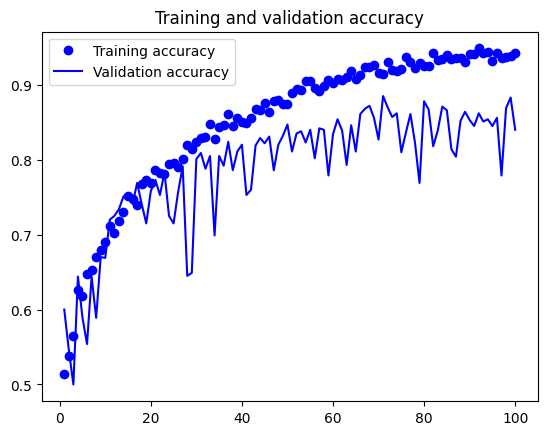

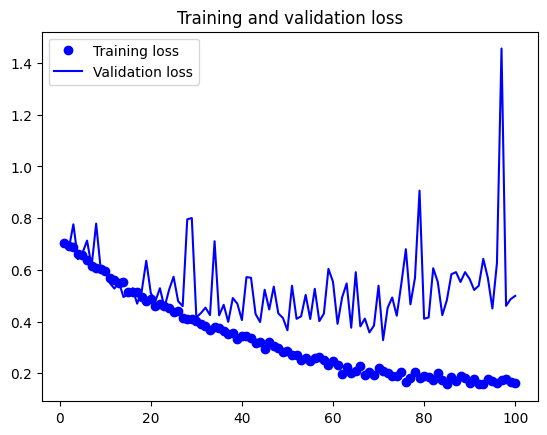

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") 
plt.title("Training and validation accuracy") 
plt.legend() 
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")

plt.plot(epochs, val_loss, "b", label="Validation loss") 
plt.title("Training and validation loss") 
plt.legend() 
plt.show()

In [96]:
test_model = keras.models.load_model( "convnet_from_scratch_with_augmentation.keras") 
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8660 - loss: 0.3908
Test accuracy: 0.868
